In [2]:
import pandas as pd

In [ ]:

#FACE CROP AND SAVE
import cv2
import sys
import os
import os
import face_recognition
import cv2


class FaceCropper(object):
    CASCADE_PATH = "Resource/haarcascade_frontalface_default.xml"

    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(self.CASCADE_PATH)

    def generate(self, image_path, show_result):
        img = cv2.imread(image_path)
        if (img is None):
            print("Can't open image file")
            return 0

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(img, 1.1, 3, minSize=(100, 100))
        if (faces is None):
            print('Failed to detect face')
            return 0

        """if (show_result):
            for (x, y, w, h) in faces:
                cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
            cv2.imshow('img', img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        """
        
        facecnt = len(faces)
        print("Detected faces: %d" % facecnt)
        i = 0
        height, width = img.shape[:2]

        for (x, y, w, h) in faces:
            r = max(w, h) / 2
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)

            faceimg = img[ny:ny+nr, nx:nx+nr]
            lastimg = cv2.resize(faceimg, (100, 100))
            i += 1
            cv2.imwrite("image%d.jpg" % i, lastimg)


if __name__ == '__main__':
    

    detecter = FaceCropper()
    detecter.generate('image_frame.jpg', True)


In [45]:
#DATASET RENAME 
import pandas as pd
import os

data=pd.read_csv("datasheet.csv")

#data.head()

l=os.listdir("train_dataset_cropped")
count = 1

for i in l:
    try:
        os.rename("train_dataset_cropped/"+i , "train_dataset_cropped/User."+str(count)+"."+str(count)+".jpg")
        #print(count)
        count+=1
    except:
        pass
    


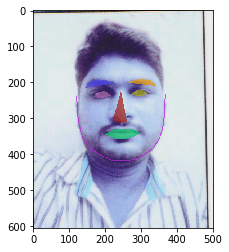

In [39]:

from collections import OrderedDict
import numpy as np
import cv2
import argparse
import dlib
import imutils

facial_features_cordinates = {}

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions
FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (48, 68)),
    ("Right_Eyebrow", (17, 22)),
    ("Left_Eyebrow", (22, 27)),
    ("Right_Eye", (36, 42)),
    ("Left_Eye", (42, 48)),
    ("Nose", (27, 35)),
    ("Jaw", (0, 17))
])





def shape_to_numpy_array(shape, dtype="int"):
    coordinates = np.zeros((68, 2), dtype=dtype)

    for i in range(0, 68):
        coordinates[i] = (shape.part(i).x, shape.part(i).y)

    return coordinates


def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
    # create two copies of the input image -- one for the
    # overlay and one for the final output image
    overlay = image.copy()
    output = image.copy()

    # if the colors list is None, initialize it with a unique
    # color for each facial landmark region
    if colors is None:
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                  (168, 100, 168), (158, 163, 32),
                  (163, 38, 32), (180, 42, 220)]

    # loop over the facial landmark regions individually
    for (i, name) in enumerate(FACIAL_LANDMARKS_INDEXES.keys()):
        # grab the (x, y)-coordinates associated with the
        # face landmark
        (j, k) = FACIAL_LANDMARKS_INDEXES[name]
        pts = shape[j:k]
        facial_features_cordinates[name] = pts

        # check if are supposed to draw the jawline
        if name == "Jaw":
            # since the jawline is a non-enclosed facial region,
            # just draw lines between the (x, y)-coordinates
            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)

        # otherwise, compute the convex hull of the facial
        # landmark coordinates points and display it
        else:
            hull = cv2.convexHull(pts)
            cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    # apply the transparent overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    # return the output image
    #print(facial_features_cordinates)
    return output

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("face_eye_ears_mapping/shape_predictor_68_face_landmarks.dat")

# load the input image, resize it, and convert it to grayscale
image = cv2.imread("face_eye_ears_mapping/test.jpg")
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_numpy_array(shape)

    output = visualize_facial_landmarks(image, shape)
    plt.imshow(output)
    #cv2.waitKey(0)

In [48]:
#FACE TRAINING 


import cv2
import numpy as np
from PIL import Image
import os
import glob
from matplotlib import pyplot as plt

# Path for face image database
path = 'train_dataset_cropped/'

recognizer = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# function to get the images and label data
def getImagesAndLabels(path):

    # imagePaths = [os.path.join(path,f) for f in os.listdir(path)]     
    imagePaths = glob.glob(path + '/*.jpg')
    faceSamples=[]
    ids = []

    for imagePath in imagePaths:

        PIL_img = Image.open(imagePath).convert('L') # convert it to grayscale
        img_numpy = np.array(PIL_img,'uint8')

        id = int(os.path.split(imagePath)[-1].split(".")[1])
        faces = detector.detectMultiScale(img_numpy)
        
        for (x,y,w,h) in faces:
            faceSamples.append(img_numpy[y:y+h,x:x+w])
            ids.append(id)
            #ids.append(1)

    return faceSamples,ids

print ("\n [INFO] Training faces. It will take a few seconds. Wait ...")
faces,ids = getImagesAndLabels(path)
recognizer.train(faces, np.array(ids))

# Save the model into trainer/trainer.yml
recognizer.write('trainer/trainer1.yml') # recognizer.save() worked on Mac, but not on Pi

# Print the numer of faces trained and end program
print("\n [INFO] faces trained. Exiting Program".format(len(np.unique(ids))))



 [INFO] Training faces. It will take a few seconds. Wait ...

 [INFO] faces trained. Exiting Program


In [37]:
l=os.listdir("train_dataset_cropped/")
print(l[330])

g1gCR 303#_61fbaab8-8f54-4d6f-aa56-d874709734d0818.jpg


In [ ]:
#TESTING DATA 

import cv2
import numpy as np
import os 
import glob
from matplotlib import pyplot as plt
%matplotlib inline


confidence_var= 70
#recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read('trainer/trainer1.yml')
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath);

count=0
accuracy=[]
image_name=[]

trainfolder="train_dataset_cropped/"

font = cv2.FONT_HERSHEY_SIMPLEX

id = 0

imagePaths = glob.glob('final_dataset_cropped/*/*')

l=os.listdir(trainfolder)




for imagePath in imagePaths:

    # ret, img =cam.read()
    img = cv2.imread(imagePath)
    # img = cv2.flip(img, -1) # Flip vertically

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #cv2.imshow('camera', gray)
    #k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    #if k == 27:
    #    break 

    faces = faceCascade.detectMultiScale( 
        gray,
        # scaleFactor = 1.2,
        # minNeighbors = 5,
        # minSize = (int(minW), int(minH)),
       )

    for(x,y,w,h) in faces:

        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

        id, confidence = recognizer.predict(gray[y:y+h,x:x+w])
        c=int(confidence)

        # Check if confidence is less then 100 ==> "0" is perfect match 
        if ((100-confidence) > 72.2 ):
            # id = names[id]
            confidence1 = "  {0}%".format(round(confidence))
            print("Confidence == " + str(100-confidence) +  "   Image Path == " + imagePath + " source image="+ l[id])
            
            count+=1
            accuracy.append(confidence)
            image_name.append(imagePath)
            
            source_img=cv2.imread(trainfolder+l[id])
            
            target_img=cv2.imread(imagePath)
            k=plt.figure()
            k.add_subplot(1,2,1)
            plt.imshow(target_img)
            k.add_subplot(1,2,2)
            plt.imshow(source_img)
            
            
            
        else:
            id = "unknown"
            confidence = "  {0}%".format(round(confidence))
        #print(id)
        cv2.putText(img, str(id), (x+5,y-5), font, 1, (255,0,0), 2)
        cv2.putText(img, str(100-int(c)), (x+5,y+h-5), font, 1, (255,255,0), 1)  
    
    cv2.imshow('camera',img) 

    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break

        
        


# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")



Confidence == 90.40203836982369   Image Path == final_dataset_cropped\cropped_arrest\g1g14_08_2018#_d0fa78cd-455a-4b84-aa42-ae29d154b5371509.jpg source image=User.10.10.jpg


Confidence values 
[8.931539268042648, 10.594781916741724, 9.080699335758723, 11.213994639524959, 11.488717991651475, 7.226148351886856, 9.756206006586671, 10.740866851128215, 7.78239843810608]


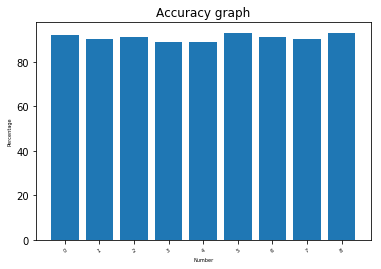

In [40]:
def plot_bar_x(label,no_movies):
    
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_movies)
    plt.xlabel('Number', fontsize=5)
    plt.ylabel('Percentage', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Accuracy graph')
    plt.show()
    
print("Confidence values ")
x=[]

for i in range(len(accuracy)):
    x.append(i)

accuracy1=[]
print(accuracy1)
print(image_name)
for i in accuracy:
    accuracy1.append(100-int(i))
    

plot_bar_x(x,accuracy1)

